In [1]:
import numpy
import matplotlib.pyplot as plt
import texplot

# Plot Facebook and NTK side by side

In [2]:
data_ntk = numpy.load('./ntk/plot_data_cifar_ntk.npy', allow_pickle=True).item()
data_facebook = numpy.load('./facebook/plot_data_snap_facebook.npy', allow_pickle=True).item()

In [9]:
def plot_axis(ax, data, xlim, ylim, title, i_start=0, pdf_at_zero=False):

    subsizes = data['subsizes']
    x_pred = data['x_pred']
    pdfs = data['pdfs']
    pdfs_pred = data['pdfs_pred']
    print(subsizes)

    num_plots = len(pdfs_pred)
    cmap = plt.get_cmap('Reds')
    # cmap = plt.get_cmap('gist_heat_r')
    colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]
    
    for i in range(i_start, len(pdfs)):
        if i != len(pdfs) - 1:
            p = int(numpy.log2(subsizes[i]) + 0.5)
            label = rf'$n=2^{{{p}}}$'
        else:
            label = rf'$n={{{subsizes[i]//1000}}}$K'

        if i == i_start:
            if pdf_at_zero:
                ax.plot(x_pred, pdfs[i], '-', color=colors[i], label=label)
            else:
                ax.plot(x_pred, pdfs_pred[i], color=colors[i], label=label)
        else:
            ax.plot(x_pred, pdfs_pred[i], color=colors[i], label=label)
        
        ax.plot(x_pred, pdfs[i], '--', color=colors[i])
        
    ax.set_xlim([xlim[0], xlim[1]])
    if ylim is None:
        ax.set_ylim(bottom=0)
    else:
        ax.set_ylim([ylim[0], ylim[1]])
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(r'$\rho(\lambda)$')
    ax.set_title(title)
    ax.legend(fontsize='x-small', facecolor='none')

[3800, 8192, 16384, 22470]
[1024, 2048, 4096, 8192, 16384, 32768, 50056]
Plot saved to "/home/sia/work/scripts/free/ntk_facebook_results.pdf".


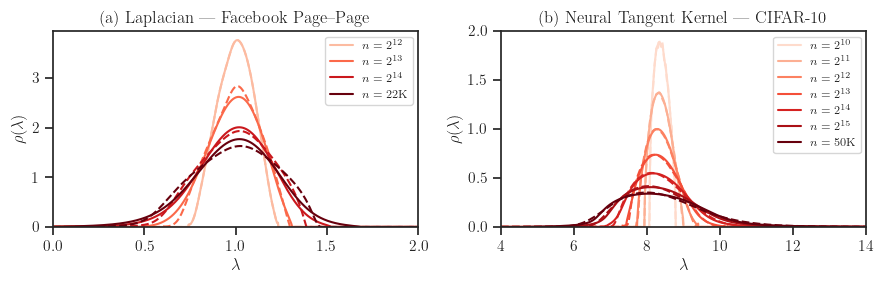

In [10]:
rc={'font.family': 'serif'}
with texplot.theme(rc=rc, use_latex=True):

    fig, ax = plt.subplots(figsize=(9, 3), ncols=2)

    plot_axis(ax[0], data_facebook, xlim=[0, 2], ylim=None, title=r'(a) Laplacian | Facebook Page--Page', i_start=0, pdf_at_zero=True)
    plot_axis(ax[1], data_ntk, xlim=[4, 14], ylim=[0, 2], title=r'(b) Neural Tangent Kernel | CIFAR-10', i_start=0, pdf_at_zero=False)
    
    plt.tight_layout()

    save_filename = 'ntk_facebook_results.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                                      transparent_background=True, dpi=200,
                                      show_and_save=True, verbose=True)

# Metircs Table (Single Sample)

Form ultiple sample (each metric is reported by mean and std, see ``ntk_multiple_batches_generate_metrics.ipynb``.

In [7]:
import numpy as np

# ===============
# total variation
# ===============

def total_variation(x, pdf, pdf_pred):
    """
    L1 total-variation distance
    """
    
    return 0.5 * np.trapz(np.abs(pdf_pred - pdf), x)


# =======================
# jensen shannon distance
# =======================

def jensen_shannon_distance(x, pdf, pdf_pred, eps=1e-12):
    """
    Jensen–Shannon distance (sqrt of divergence).
    Adds eps to avoid log(0) and renormalizes internally.
    """
    
    # Ensure valid densities and normalize
    p = pdf + eps
    q = pdf_pred + eps
    p /= np.trapz(p, x)
    q /= np.trapz(q, x)

    m = 0.5 * (p + q)
    kl_pm = np.trapz(p * np.log2(p / m), x)
    kl_qm = np.trapz(q * np.log2(q / m), x)
    js_div = 0.5 * (kl_pm + kl_qm)

    return np.sqrt(js_div)
    

# ===============
# moment from pdf
# ===============

def moment_from_pdf(pdf, x, k):
    """
    k-th raw moment.
    """
    
    mass = np.trapz(pdf, x)
    return np.trapz((x**k) * pdf / mass, x)


# ===============
# moment from eig
# ===============

def moment_from_eig(eig, k):
    """
    k‑th raw moment of the empirical spectrum (no KDE).
    """
    
    eig = np.asarray(eig)
    return np.mean(eig**k)
    

# ======================
# relatoive moment error
# ======================

def relative_moment_error(x, eig, pdf_pred, k):
    """
    Relative error in k-th moment.
    """

    m_true = moment_from_eig(eig, k)
    m_pred = moment_from_pdf(pdf_pred, x, k)
    return abs(m_pred - m_true) / abs(m_true)


# =====
# table
# =====

def table(data):
    
    subsizes = data['subsizes']
    eigs = data['eigs']
    x_pred = data['x_pred']
    pdfs = data['pdfs']
    pdfs_pred = data['pdfs_pred']
    
    for i in range(len(pdfs)):
        tv = 100 * total_variation(x_pred, pdfs[i], pdfs_pred[i])
        js = 100 * jensen_shannon_distance(x_pred, pdfs[i], pdfs_pred[i])
        mp1 = 100.0 * relative_moment_error(x_pred, eigs[i], pdfs_pred[i], 1)
        mp2 = 100.0 * relative_moment_error(x_pred, eigs[i], pdfs_pred[i], 2)
        
        print(f'| i: {i} | size: {subsizes[i]:>5d} | tv: {tv:>0.2f} | js: {js:>0.2f} | ', end='')
        print(f'mp1: {mp1:>5.3f} | mp2: {mp2:>5.3f} |')

In [8]:
table(data_ntk)

| i: 0 | size:  1024 | tv: 0.71 | js: 2.74 | mp1: 0.001 | mp2: 0.002 |
| i: 1 | size:  2048 | tv: 0.62 | js: 1.56 | mp1: 0.005 | mp2: 0.010 |
| i: 2 | size:  4096 | tv: 1.25 | js: 3.96 | mp1: 0.006 | mp2: 0.012 |
| i: 3 | size:  8192 | tv: 1.87 | js: 5.17 | mp1: 0.018 | mp2: 0.037 |
| i: 4 | size: 16384 | tv: 2.34 | js: 5.60 | mp1: 0.024 | mp2: 0.053 |
| i: 5 | size: 32768 | tv: 2.70 | js: 5.44 | mp1: 0.024 | mp2: 0.053 |
| i: 6 | size: 50056 | tv: 3.35 | js: 5.48 | mp1: 0.194 | mp2: 0.525 |
